In [273]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv
import torch

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [296]:
axis_normalization = np.array([5.0, 1.0, 0.5])

In [297]:
r"2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"

'2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4'

In [298]:
# img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob("*/Anasto*.mp4"))
img_pths = list(
    Path("../piglegsurgeryweb/media/upload/").glob(
        "*/2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"
    )
)
img_pths[0]

PosixPath('../piglegsurgeryweb/media/upload/20231011-191116_2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht_2420162e9b953df5fcaf26ac64f0bd3a7ae78c36/2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4')

In [299]:
img_pths = list(
    Path("../piglegsurgeryweb/media/").glob(
        "**/*2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4.zip"
    )
)
zip_path = img_pths[0]

In [300]:
points_path = zip_path.parent  # / "tracks_points.json"
points_path.exists()

True

In [301]:
outputdir = list(zip_path.parent.glob("*"))[0]

In [302]:
list(outputdir.glob("*"))
points_path = outputdir / "tracks_points.json"
points_path.exists()

True

In [303]:
import json


with open(points_path, "r") as f:
    data = json.load(f)

In [304]:
data.keys()

dict_keys(['frame_ids', 'data_pixels_0', 'data_pixels_1', 'data_pixels_2', 'data_pixels_3'])

In [305]:
import numpy as np

from sklearn.cluster import (
    MeanShift,
    estimate_bandwidth,
    SpectralClustering,
    KMeans,
    DBSCAN,
)
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

In [306]:
for k in data:
    print(k, len(data[k]))

frame_ids 4
data_pixels_0 6189
data_pixels_1 3419
data_pixels_2 4854
data_pixels_3 0


In [307]:
len(data["frame_ids"][0])

6189

In [308]:
# data["data_pixels_0"]

3419


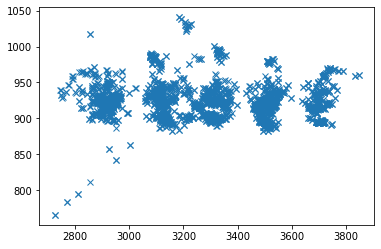

In [309]:
# X = np.concatenate([data["data_pixels_0"], data["frame_ids"]], axis=2)
tool_index = 1
X = np.asarray(data[f"data_pixels_{tool_index}"])

time = np.asarray(list(range(X.shape[0]))).reshape(-1, 1)
time = np.asarray(data["frame_ids"][tool_index]).reshape(-1, 1)

X = np.concatenate([X, time], axis=1)
X = X * axis_normalization
print(len(X))
# plt.
plt.plot(X[:, 0], X[:, 1], "x")
# np.asarray(X)

In [310]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = KMeans(n_clusters=5)
# ms = DBSCAN()
# ms = SpectralClustering()
# ms = SpectralClustering(3, affinity='precomputed', n_init=100,
#                       assign_labels='discretize')
# ms = GaussianMixture()
ms.fit(X)
labels = ms.labels_
# labels = ms.predict(X)
cluster_centers = ms.cluster_centers_

/opt/conda/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [311]:
labels
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 5


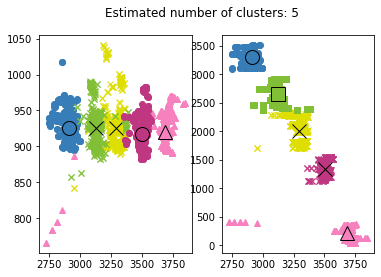

In [312]:
import matplotlib.pyplot as plt

plt.subplot(121)
# plt.figure(1)
# plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf", "#81bf37", "#bf3781", "#f3781b"]
markers = [
    "x",
    "o",
    "^",
    "x",
    "o",
    "^",
]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
# plt.title("Estimated number of clusters: %d" % n_clusters_)

plt.subplot(122)
colors = [
    "#dede00",
    "#377eb8",
    "#f781bf",
    "#81bf37",
    "#bf3781",
    "#f3781b",
    "#eb88b1",
    "#1bff78",
]
markers = [
    "x",
    "o",
    "^",
    "s",
    "x",
    "o",
    "^",
    "x",
    "o",
    "^",
    "x",
    "o",
    "^",
]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 2], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[2],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.suptitle("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [313]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=200.001, min_samples=100).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 10


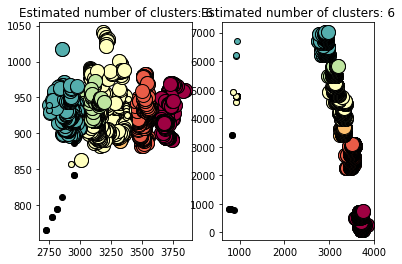

In [292]:
plt.subplot(121)
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")

plt.subplot(122)
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 2],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 1],
        xy[:, 2],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

plt.show()